<a href="https://colab.research.google.com/github/Indhu1725/Neural-Network/blob/main/indira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel('/content/drive/MyDrive/datasets4phd/indira.xlsx')


In [ ]:
df.head(10)

,Date,Invertor1
0,2021-10-01,182.6
1,2021-10-02,170.9
2,2021-10-03,169.4
3,2021-10-04,174.7
4,2021-10-05,166.8
5,2021-10-06,191.9
6,2021-10-07,173.9
7,2021-10-08,120.1
8,2021-10-09,198.0
9,2021-10-10,187.4


In [ ]:
df.shape

(90, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       90 non-null     datetime64[ns]
 1   Invertor1  90 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df[['Invertor1']].values)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)

# Split into train and test sets
values = reframed.values
n_train_days = int(len(values) * 0.96)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
2/2 - 3s - loss: 0.6365 - val_loss: 0.6119 - 3s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 0.6252 - val_loss: 0.6009 - 37ms/epoch - 19ms/step
Epoch 3/50
2/2 - 0s - loss: 0.6139 - val_loss: 0.5899 - 37ms/epoch - 18ms/step
Epoch 4/50
2/2 - 0s - loss: 0.6025 - val_loss: 0.5788 - 40ms/epoch - 20ms/step
Epoch 5/50
2/2 - 0s - loss: 0.5911 - val_loss: 0.5676 - 38ms/epoch - 19ms/step
Epoch 6/50
2/2 - 0s - loss: 0.5796 - val_loss: 0.5564 - 40ms/epoch - 20ms/step
Epoch 7/50
2/2 - 0s - loss: 0.5681 - val_loss: 0.5452 - 37ms/epoch - 19ms/step
Epoch 8/50
2/2 - 0s - loss: 0.5564 - val_loss: 0.5338 - 39ms/epoch - 19ms/step
Epoch 9/50
2/2 - 0s - loss: 0.5447 - val_loss: 0.5224 - 39ms/epoch - 19ms/step
Epoch 10/50
2/2 - 0s - loss: 0.5330 - val_loss: 0.5108 - 39ms/epoch - 19ms/step
Epoch 11/50
2/2 - 0s - loss: 0.5214 - val_loss: 0.4992 - 42ms/epoch - 21ms/step
Epoch 12/50
2/2 - 0s - loss: 0.5096 - val_loss: 0.4874 - 38ms/epoch - 19ms/step
Epoch 13/50
2/2 - 0s - loss: 0.4976 - val_loss: 0.475

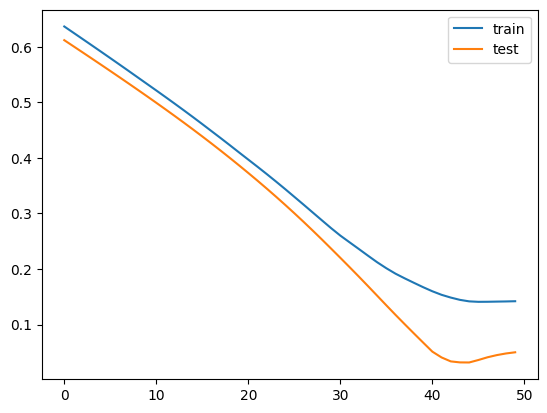

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


1/1 [==============================] - 1s 682ms/step


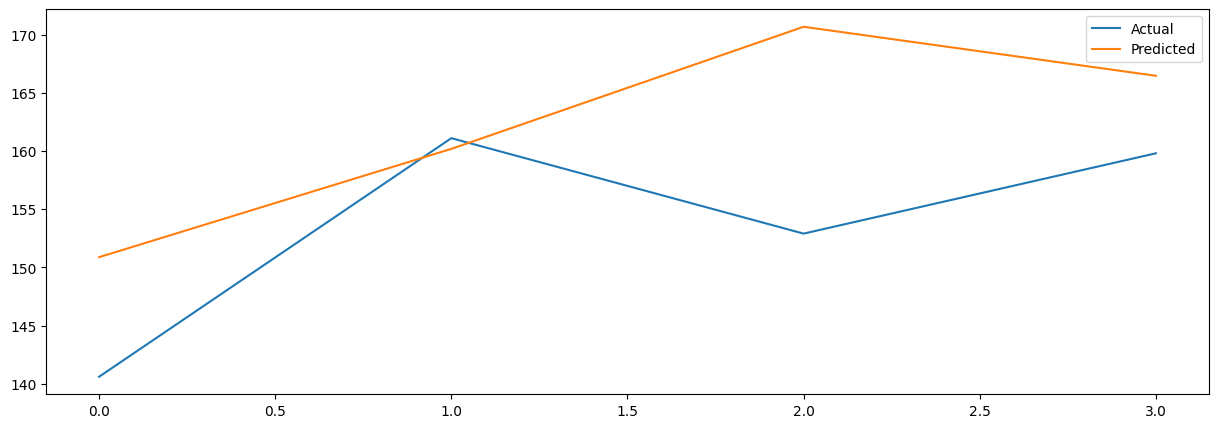

In [ ]:
# Make predictions
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y.reshape(len(test_y), 1))

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.plot(inv_y, label='Actual')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming inv_yhat and inv_y are your predicted and actual values, respectively, in their original scale

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 10.800


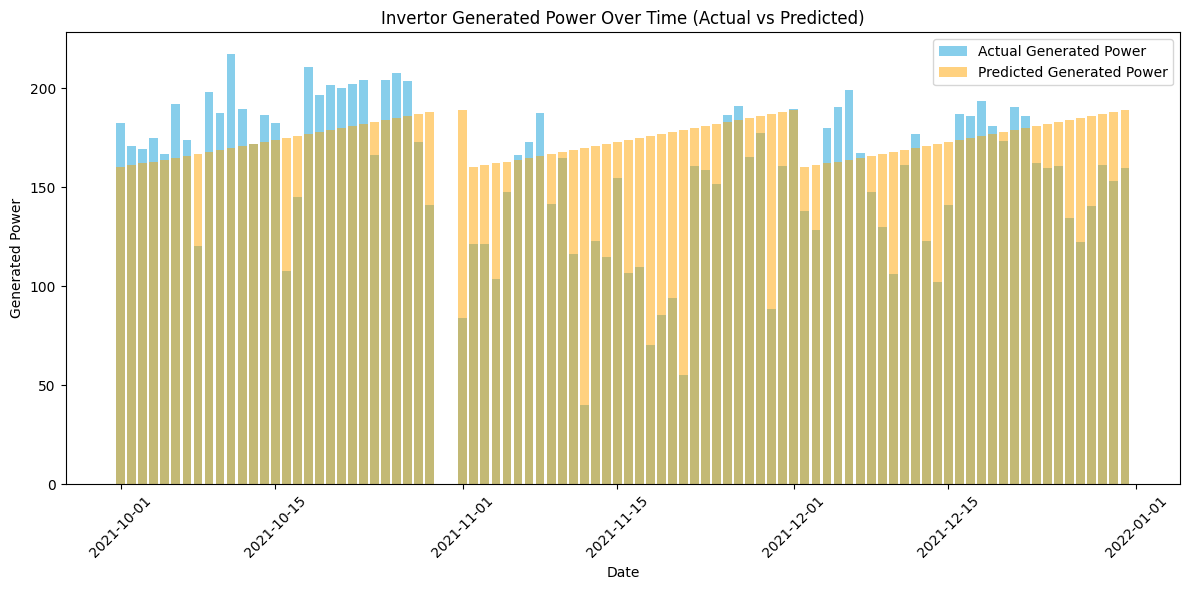

In [ ]:
# Placeholder for predicted values - replace this with your actual predictions
predicted_values = [160 + (i % 30) for i in range(len(df['Date']))]  # Hypothetical predictions

# Plotting actual values
plt.figure(figsize=(12, 6))
plt.bar(df['Date'], df['Invertor1'], color='skyblue', label='Actual Generated Power')

# Adding predicted values to the plot
plt.bar(df['Date'], predicted_values, color='orange', alpha=0.5, label='Predicted Generated Power')

plt.xlabel('Date')
plt.ylabel('Generated Power')
plt.title('Invertor Generated Power Over Time (Actual vs Predicted)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()
